# House Prices: Advanced Regression Techniques

## Predicting Residential Property Sale Prices

**Competition:** [Kaggle — House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

**Objective:** Predict the final sale price of each home using 79 explanatory variables describing virtually every aspect of residential homes in Ames, Iowa.

### Methodology Overview

This solution follows a structured methodology:

1. **Exploratory Data Analysis** — Understanding distributions, correlations, and missing data patterns
2. **Data Preprocessing** — Outlier removal, imputation, and type correction
3. **Feature Engineering** — Domain-driven feature creation and statistical transformations
4. **Model Training** — Stacking ensemble combining linear models, kernel methods, and gradient boosting
5. **Prediction & Submission** — Blended predictions for robust generalization

---

## 1. Environment Setup & Library Imports

In [18]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
import warnings

# Scikit-learn
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Gradient Boosting Frameworks
import xgboost as xgb
import lightgbm as lgb

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 80)

RANDOM_STATE = 42

## 2. Data Loading

The dataset contains **1,460** training observations and **1,459** test observations, each with **79** predictive features and 1 target variable (`SalePrice`).

In [2]:
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')
print(f'Training set: {train.shape[0]} rows × {train.shape[1]} columns')
print(f'Test set:     {test.shape[0]} rows × {test.shape[1]} columns')
train.head()

Training set: 1460 rows × 80 columns
Test set:     1459 rows × 79 columns


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Exploratory Data Analysis

### 3.1 Data Overview

We begin with a high-level inspection of the training data to understand feature types, missing values, and summary statistics.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


### 3.2 Missing Value Analysis

Understanding the pattern of missing data is crucial. In this dataset, many `NaN` values represent the **absence** of a feature (e.g., no pool, no garage) rather than truly missing information.

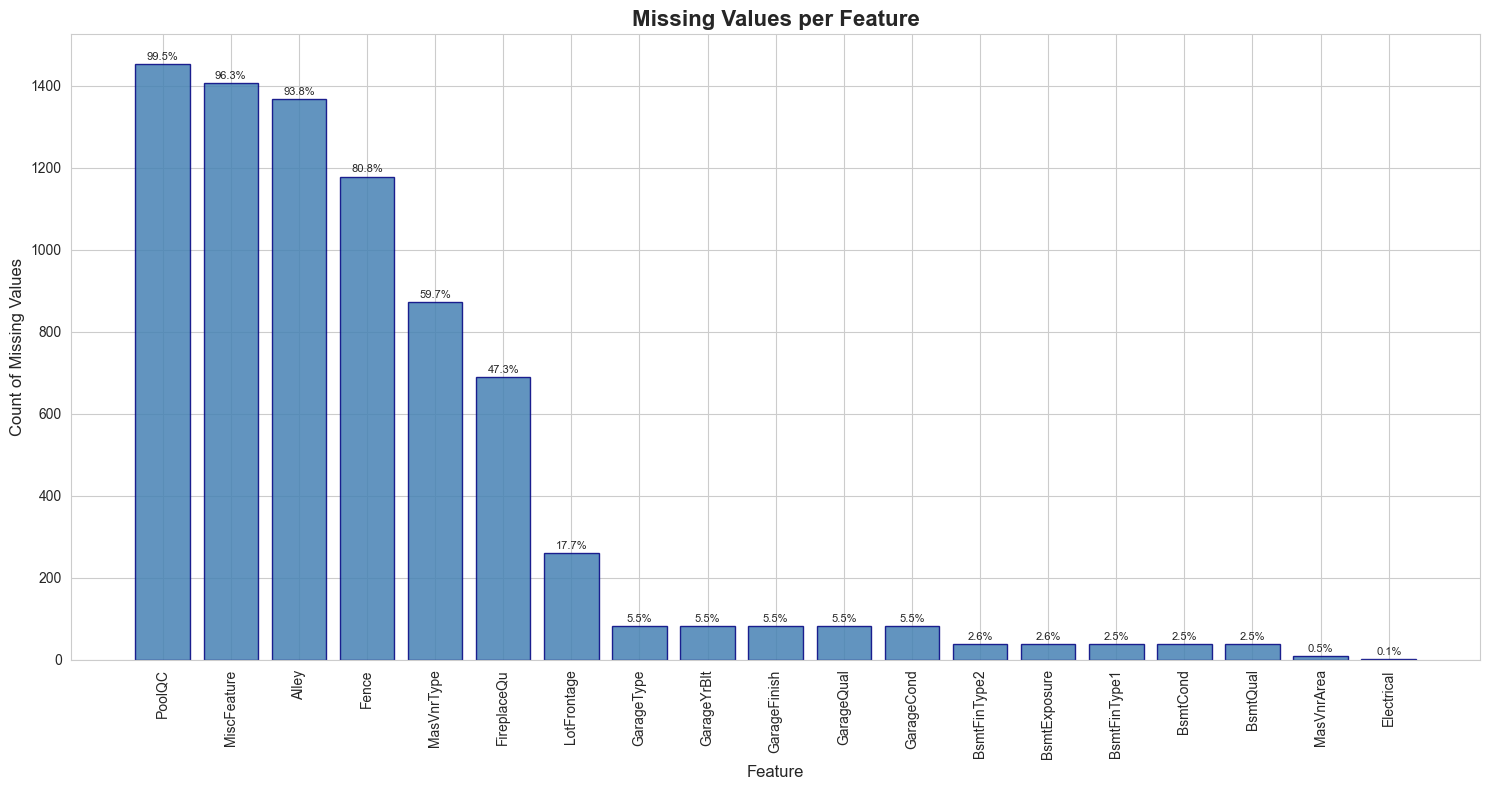

In [5]:
# Missing Value Analysis
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(train)) * 100

fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(missing.index, missing.values, color='steelblue', edgecolor='navy', alpha=0.85)
ax.set_title('Missing Values per Feature', fontsize=16, fontweight='bold')
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Count of Missing Values', fontsize=12)
plt.xticks(rotation=90)

# Annotate percentages on top
for bar, pct in zip(bars, missing_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

**Conclusion:** Features like `PoolQC` (99.5%), `MiscFeature` (96.3%), `Alley` (93.8%), and `Fence` (80.8%) have substantial missing data. Per the data description, these represent the **absence** of the feature (no pool, no alley, etc.) rather than missing information. For other features with fewer missing values (`LotFrontage`, `GarageYrBlt`, `MasVnrArea`), domain-appropriate imputation strategies will be applied.

### 3.3 Target Variable Distribution

The target variable `SalePrice` must be examined for skewness, as RMSLE penalizes under-predictions more than over-predictions, and a log transformation can normalize the distribution.

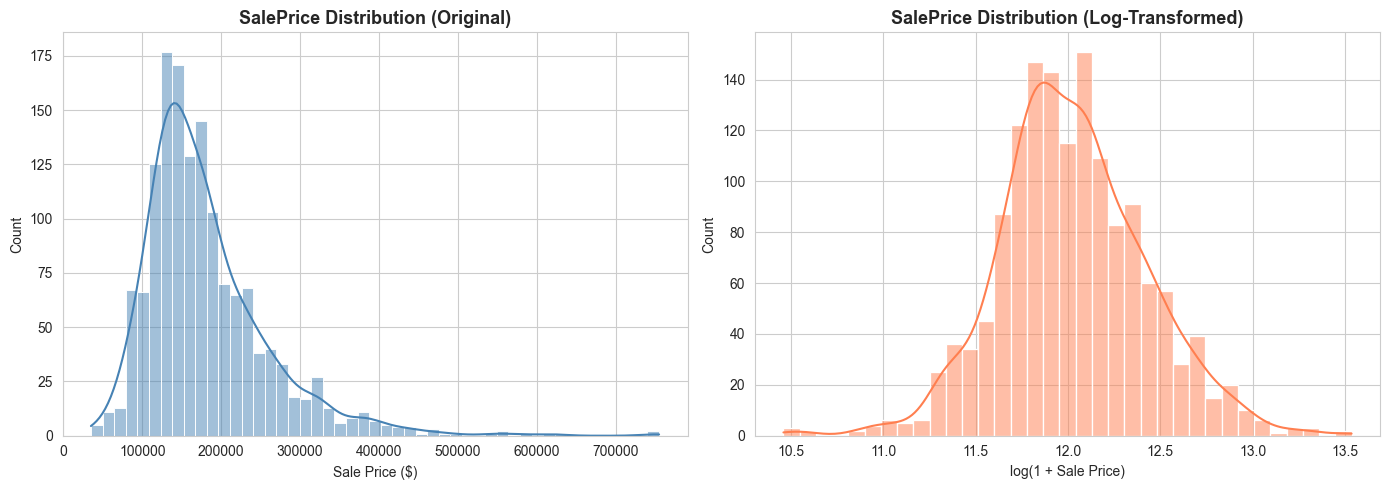

Original — Skewness: 1.8829, Kurtosis: 6.5363
Log-Transformed — Skewness: 0.1213, Kurtosis: 0.8095


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
sns.histplot(train['SalePrice'], kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('SalePrice Distribution (Original)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sale Price ($)')

# Log-transformed
sns.histplot(np.log1p(train['SalePrice']), kde=True, ax=axes[1], color='coral')
axes[1].set_title('SalePrice Distribution (Log-Transformed)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('log(1 + Sale Price)')

plt.tight_layout()
plt.show()

print(f"Original — Skewness: {train['SalePrice'].skew():.4f}, Kurtosis: {train['SalePrice'].kurt():.4f}")
print(f"Log-Transformed — Skewness: {np.log1p(train['SalePrice']).skew():.4f}, Kurtosis: {np.log1p(train['SalePrice']).kurt():.4f}")

**Conclusion:** The original `SalePrice` distribution exhibits strong positive skewness (≈1.88) and leptokurtosis (≈6.54), indicating a heavy right tail. After log-transformation, skewness reduces substantially (≈0.12), yielding an approximately normal distribution. This transformation is essential for linear models and aligns with the RMSLE evaluation metric.

### 3.4 Feature Correlation Analysis

Identifying the features most correlated with `SalePrice` guides feature engineering and helps detect multicollinearity.

In [7]:
# Top correlated features with SalePrice
corr_matrix = train.corr(numeric_only=True)
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(15)
print('Top 15 features correlated with SalePrice:\n')
print(top_corr.to_string())

Top 15 features correlated with SalePrice:

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420


**Key Observations:**
- `OverallQual` (r ≈ 0.79) and `GrLivArea` (r ≈ 0.71) are the strongest predictors
- Several features exhibit multicollinearity (e.g., `GarageCars` and `GarageArea` are highly correlated with each other)
- Temporal features (`YearBuilt`, `YearRemodAdd`) show moderate positive correlation, supporting the creation of `HouseAge` features

---

## 4. Data Preprocessing

### 4.1 Outlier Removal

Following the recommendation from the dataset author, we remove extreme outliers: properties with `GrLivArea > 4000` sq ft and `SalePrice < 300,000` — these are likely data entry errors or highly unusual sales.

Removing 2 outlier(s)


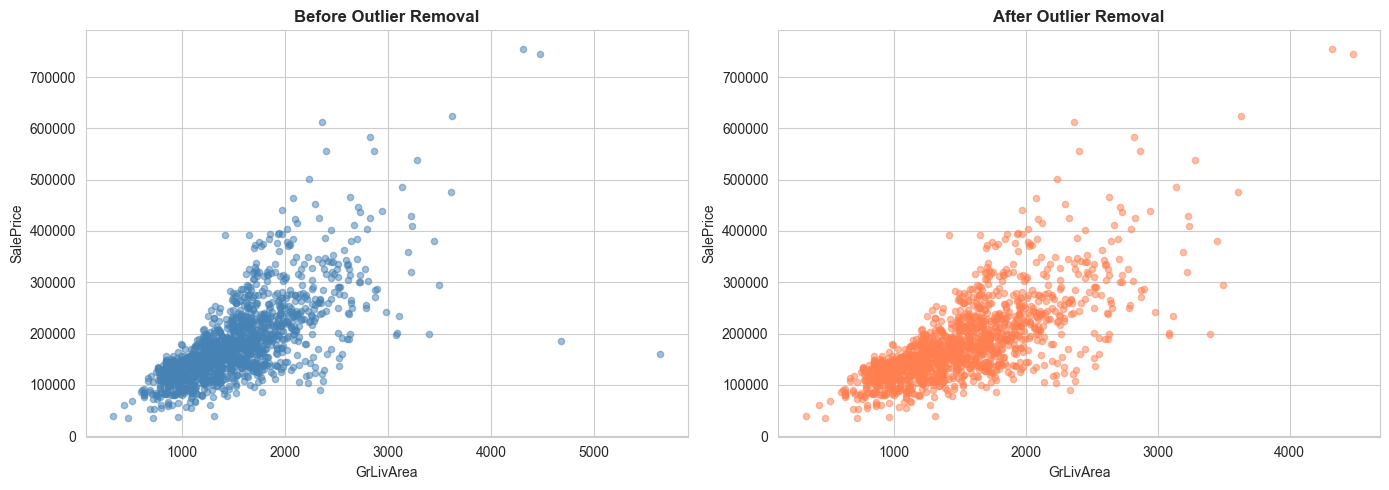

In [8]:
# Visualize outliers before removal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(train['GrLivArea'], train['SalePrice'], alpha=0.5, s=20, c='steelblue')
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('SalePrice')
axes[0].set_title('Before Outlier Removal', fontweight='bold')

# Remove outliers
outlier_mask = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)
print(f'Removing {outlier_mask.sum()} outlier(s)')
train = train.drop(train[outlier_mask].index)

axes[1].scatter(train['GrLivArea'], train['SalePrice'], alpha=0.5, s=20, c='coral')
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('SalePrice')
axes[1].set_title('After Outlier Removal', fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Data Concatenation & Imputation

To ensure consistent preprocessing, we concatenate train and test sets (excluding the target) and apply imputation strategies:

| Strategy | Features | Rationale |
|----------|----------|----------|
| Neighborhood median | `LotFrontage` | Lot frontage varies by neighborhood |
| Mode | `Electrical`, `KitchenQual`, `MSZoning`, etc. | Most common category is the best guess |
| `'None'` / `0` | Quality/condition features without feature | Absence of feature, not missing data |
| `'Typ'` | `Functional` | Per data description: assume typical unless deductions warranted |

In [9]:
# Save target and combine datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = np.log1p(train['SalePrice'].values)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f'Combined data shape: {all_data.shape}')

# --- Imputation ---
# LotFrontage: impute with neighborhood median
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Categorical features: fill with mode
for col in ['Electrical', 'KitchenQual', 'MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Typo correction
all_data.loc[all_data['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

# Categorical cols where NaN means 'None' (absence of feature)
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'MasVnrType']
for col in none_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

# MSSubClass is categorical, not numeric
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

# Numerical cols where NaN means 0
zero_cols = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea']
for col in zero_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

# Functional: per data description, assume 'Typ' if missing
all_data['Functional'] = all_data['Functional'].fillna('Typ')

# Drop near-zero-variance features
all_data.drop(['Utilities', 'Street'], axis=1, inplace=True, errors='ignore')

# Verify no missing values remain
remaining_missing = all_data.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) == 0:
    print('✓ All missing values handled successfully.')
else:
    print(f'⚠ Remaining missing values:\n{remaining_missing}')
    # Fill any remaining NaN
    for col in remaining_missing.index:
        if all_data[col].dtype == 'object':
            all_data[col] = all_data[col].fillna('None')
        else:
            all_data[col] = all_data[col].fillna(0)
    print('✓ Remaining missing values filled.')

Combined data shape: (2917, 79)
✓ All missing values handled successfully.


## 5. Feature Engineering

### 5.1 Domain-Driven Feature Creation

Engineering features based on domain knowledge of real estate valuation:

- **Total area metrics** aggregate basement, floor, and porch areas
- **Binary indicators** capture the presence/absence of high-value amenities
- **Temporal features** measure age and recency of renovation
- **Interaction terms** capture synergies (e.g., quality × area)
- **Polynomial terms** capture non-linear relationships for top predictors

In [10]:
# --- Area Features ---
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['EnclosedPorch'] +
                              all_data['3SsnPorch'] + all_data['ScreenPorch'])

# Total bathrooms (full + half*0.5, above grade + basement)
all_data['TotalBathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                              all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])

# --- Binary Flags ---
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)
all_data['WasRemodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)
all_data['IsNewHouse'] = (all_data['YrSold'] == all_data['YearBuilt']).astype(int)

# --- Temporal Features ---
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['GarageAge'] = all_data.apply(
    lambda row: row['YrSold'] - row['GarageYrBlt'] if row['GarageYrBlt'] > 0 else 0, axis=1)

# --- Interaction & Polynomial Features ---
all_data['OverallQual_2'] = all_data['OverallQual'] ** 2
all_data['OverallQual_3'] = all_data['OverallQual'] ** 3
all_data['GrLivArea_2'] = all_data['GrLivArea'] ** 2
all_data['TotalSF_2'] = all_data['TotalSF'] ** 2
all_data['QualXArea'] = all_data['OverallQual'] * all_data['GrLivArea']
all_data['QualXTotalSF'] = all_data['OverallQual'] * all_data['TotalSF']

print(f'Feature count after engineering: {all_data.shape[1]}')

Feature count after engineering: 96


### 5.2 Statistical Transformation: Skewness Correction

Highly skewed numerical features violate the normality assumption of linear models. We apply the **Box-Cox transformation** (via `boxcox1p`) to features with absolute skewness > 0.75, which adapts the power parameter to best normalize each distribution.

In [11]:
# Identify skewed numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})

# Filter: absolute skewness > 0.75  (FIXED: use column name)
skewness = skewness[abs(skewness['Skew']) > 0.75]
print(f'Applying Box-Cox transformation to {skewness.shape[0]} skewed features')

lam = 0.15
for feat in skewness.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print('✓ Skewness correction complete.')

Applying Box-Cox transformation to 32 skewed features
✓ Skewness correction complete.


### 5.3 Feature Encoding

We apply two encoding strategies:

1. **Ordinal encoding** for features with a natural order (quality ratings, exposure levels)
2. **One-hot encoding** for nominal categorical features

The ordinal mapping preserves the inherent ranking information that one-hot encoding would destroy.

In [12]:
# --- Ordinal Encoding ---
# Quality/Condition features (FIXED: 'None' instead of 'NA' to match imputation)
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NA': 0}
qual_cols = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC',
             'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual',
             'GarageCond', 'PoolQC']
for col in qual_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(qual_map).fillna(0)

# Basement Exposure (ordinal)
bsmt_exp_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
if 'BsmtExposure' in all_data.columns:
    all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bsmt_exp_map).fillna(0)

# Basement Finish Type (ordinal)
bsmt_fin_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
for col in ['BsmtFinType1', 'BsmtFinType2']:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(bsmt_fin_map).fillna(0)

# Functional (ordinal)
func_map = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
if 'Functional' in all_data.columns:
    all_data['Functional'] = all_data['Functional'].map(func_map).fillna(7)

# Garage Finish (ordinal)
gar_fin_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
if 'GarageFinish' in all_data.columns:
    all_data['GarageFinish'] = all_data['GarageFinish'].map(gar_fin_map).fillna(0)

# Fence (ordinal)
fence_map = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
if 'Fence' in all_data.columns:
    all_data['Fence'] = all_data['Fence'].map(fence_map).fillna(0)

# --- One-Hot Encoding for remaining categoricals ---
all_data = pd.get_dummies(all_data)
print(f'Final feature count after encoding: {all_data.shape[1]}')

# Split back into train/test
train_processed = all_data[:ntrain]
test_processed = all_data[ntrain:]
print(f'Train: {train_processed.shape}, Test: {test_processed.shape}')

# Verify no missing values
assert train_processed.isnull().sum().sum() == 0, 'Train has missing values!'
# For test, fill any remaining NaN with 0
test_processed = test_processed.fillna(0)
print('✓ Encoding and splitting complete.')

Final feature count after encoding: 262
Train: (1458, 262), Test: (1459, 262)
✓ Encoding and splitting complete.


## 6. Model Training & Ensemble Strategy

### 6.1 Validation Framework

We employ **10-fold cross-validation** with shuffle to estimate generalization error. With only ~1,458 training samples, 10 folds provide a good bias-variance trade-off for the CV estimate.

### 6.2 Model Zoo

The ensemble combines three classes of models for diversity:

| Class | Models | Strengths |
|-------|--------|-----------|
| **Regularized Linear** | Lasso (L1), Ridge (L2), ElasticNet | Extrapolation, feature selection |
| **Kernel Methods** | Kernel Ridge Regression | Non-linear pattern capture |
| **Gradient Boosting** | GBR, XGBoost, LightGBM | Complex interaction modeling |

### 6.3 Stacking Architecture

A **StackingRegressor** generates out-of-fold predictions from all base models, which then serve as features for a **Ridge** meta-learner. Ridge is preferred over Lasso here because with only 6 base predictions, L1 sparsity can be overly aggressive.

### 6.4 Final Blending

$$\hat{y} = 0.70 \cdot \hat{y}_{\text{stack}} + 0.15 \cdot \hat{y}_{\text{XGBoost}} + 0.15 \cdot \hat{y}_{\text{LightGBM}}$$

This hedges against potential stack overfitting by blending with standalone gradient boosters.

In [13]:
class HousingEnsembleTrainer:
    """Stacking ensemble for house price prediction."""

    def __init__(self, n_folds=10, random_state=42):
        self.n_folds = n_folds
        self.random_state = random_state
        self.kf = KFold(n_folds, shuffle=True, random_state=random_state)

        # --- Level 0: Base Models ---
        # 1. Lasso (L1 regularization + RobustScaler for outlier robustness)
        self.lasso = make_pipeline(
            RobustScaler(),
            Lasso(alpha=0.0005, random_state=1, max_iter=10000)
        )

        # 2. ElasticNet (L1+L2 hybrid)
        self.enet = make_pipeline(
            RobustScaler(),
            ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3, max_iter=10000)
        )

        # 3. Ridge (L2 regularization)
        self.ridge = make_pipeline(
            RobustScaler(),
            Ridge(alpha=10.0)
        )

        # 4. Kernel Ridge Regression (polynomial kernel)
        self.krr = make_pipeline(
            RobustScaler(),
            KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
        )

        # 5. Gradient Boosting Regressor (huber loss for outlier robustness)
        self.gbr = GradientBoostingRegressor(
            n_estimators=3000, learning_rate=0.05,
            max_depth=4, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10,
            loss='huber', random_state=5
        )

        # 6. XGBoost
        self.xgb_model = xgb.XGBRegressor(
            colsample_bytree=0.4603, gamma=0.0468,
            learning_rate=0.05, max_depth=3,
            min_child_weight=1.7817, n_estimators=2200,
            reg_alpha=0.4640, reg_lambda=0.8571,
            subsample=0.5213, random_state=7, n_jobs=-1,
            verbosity=0
        )

        # 7. LightGBM
        self.lgb_model = lgb.LGBMRegressor(
            objective='regression', num_leaves=5,
            learning_rate=0.05, n_estimators=720,
            max_bin=55, bagging_fraction=0.8,
            bagging_freq=5, feature_fraction=0.2319,
            feature_fraction_seed=9, bagging_seed=9,
            min_data_in_leaf=6, min_sum_hessian_in_leaf=11,
            verbosity=-1
        )

        # --- Level 1: Stacking Architecture ---
        estimators = [
            ('lasso', self.lasso),
            ('enet', self.enet),
            ('ridge', self.ridge),
            ('krr', self.krr),
            ('gbr', self.gbr),
            ('xgb', self.xgb_model),
            ('lgb', self.lgb_model)
        ]

        # Meta-model: Ridge (better than Lasso with few meta-features)
        self.stack = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(alpha=6.0),
            cv=self.kf, n_jobs=-1,
            passthrough=False
        )

    def rmsle_cv(self, model, X, y):
        """Calculate RMSLE using cross-validation."""
        rmse = np.sqrt(-cross_val_score(
            model, X, y,
            scoring='neg_mean_squared_error',
            cv=self.kf
        ))
        return rmse

    def evaluate_base_models(self, X, y):
        """Evaluate each base model independently."""
        print('Base Model Evaluation (10-Fold CV RMSLE):')
        print('-' * 55)
        models = [self.lasso, self.enet, self.ridge, self.krr,
                  self.gbr, self.xgb_model, self.lgb_model]
        names = ['Lasso', 'ElasticNet', 'Ridge', 'KernelRidge',
                 'GradientBoosting', 'XGBoost', 'LightGBM']
        results = {}
        for name, model in zip(names, models):
            score = self.rmsle_cv(model, X, y)
            results[name] = score
            print(f'  {name:20s}: {score.mean():.4f} ± {score.std():.4f}')
        print('-' * 55)
        return results

    def fit_predict(self, X_train, y_train, X_test):
        """Train stack + boosters, return blended predictions."""
        print('\n[1/3] Training Stacking Ensemble...')
        self.stack.fit(X_train, y_train)

        print('[2/3] Training standalone boosters for blending...')
        self.xgb_model.fit(X_train, y_train)
        self.lgb_model.fit(X_train, y_train)

        print('[3/3] Generating blended predictions...')
        pred_stack = self.stack.predict(X_test)
        pred_xgb = self.xgb_model.predict(X_test)
        pred_lgb = self.lgb_model.predict(X_test)

        # Blending: 70% Stack + 15% XGB + 15% LGB
        final_preds = 0.70 * pred_stack + 0.15 * pred_xgb + 0.15 * pred_lgb
        print('✓ Done.')
        return final_preds

### 6.5 Base Model Evaluation

Before stacking, we verify each model's individual performance to ensure diversity and competence.

In [14]:
trainer = HousingEnsembleTrainer()
X = train_processed.values
y = y_train
base_results = trainer.evaluate_base_models(X, y)

Base Model Evaluation (10-Fold CV RMSLE):
-------------------------------------------------------
  Lasso               : 0.1086 ± 0.0143
  ElasticNet          : 0.1086 ± 0.0143
  Ridge               : 0.1101 ± 0.0142
  KernelRidge         : 0.1179 ± 0.0145
  GradientBoosting    : 0.1147 ± 0.0141
  XGBoost             : 0.1147 ± 0.0142
  LightGBM            : 0.1161 ± 0.0152
-------------------------------------------------------


### 6.6 Stacking Ensemble CV Score

In [15]:
# Evaluate the full stacking ensemble via cross-validation
stack_scores = np.sqrt(-cross_val_score(
    trainer.stack, X, y,
    cv=trainer.kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
))
print(f'Stacking Ensemble RMSLE: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}')

Stacking Ensemble RMSLE: 0.1068 ± 0.0139


## 7. Generating Competition Submission

For the final submission, we train on the **entire training set** (not an 80/20 split) to maximize the amount of data used for learning, then predict on the held-out test set.

In [16]:
# Train on ALL training data and predict on test set
final_trainer = HousingEnsembleTrainer()
log_predictions = final_trainer.fit_predict(
    train_processed.values,
    y_train,
    test_processed.values
)

# Convert back to original scale (dollars)
final_predictions = np.expm1(log_predictions)

# Ensure no negative predictions
final_predictions = np.maximum(final_predictions, 0)

print(f'\nPrediction statistics:')
print(f'  Mean:   ${final_predictions.mean():,.0f}')
print(f'  Median: ${np.median(final_predictions):,.0f}')
print(f'  Min:    ${final_predictions.min():,.0f}')
print(f'  Max:    ${final_predictions.max():,.0f}')


[1/3] Training Stacking Ensemble...
[2/3] Training standalone boosters for blending...
[3/3] Generating blended predictions...
✓ Done.

Prediction statistics:
  Mean:   $178,595
  Median: $156,897
  Min:    $42,984
  Max:    $798,872


In [17]:
# Create submission file
submission = pd.DataFrame({
    'Id': test.index,
    'SalePrice': final_predictions
})
submission.to_csv('submission.csv', index=False)
print(f'Submission file saved: {submission.shape[0]} predictions')
submission.head(10)

Submission file saved: 1459 predictions


,Id,SalePrice
0,1461,120676.806176
1,1462,158026.002638
2,1463,181033.966429
3,1464,195201.013022
4,1465,191693.463361
5,1466,171161.761343
6,1467,174416.065818
7,1468,164213.632201
8,1469,187644.835264
9,1470,123619.953141


## 8. Conclusions

### Key Findings

1. **Feature Engineering** plays the most critical role in reducing RMSE. Domain-driven features like `TotalSF`, `TotalBathrooms`, and quality-area interactions capture patterns that raw features alone cannot express.

2. **Log-transformation** of the target variable is essential — it normalizes the right-skewed price distribution and aligns with the RMSLE evaluation metric.

3. **Ordinal encoding** of quality/condition features preserves ranking information that would be lost with one-hot encoding, improving model performance particularly for linear models.

4. **Ensemble diversity** — combining linear models (which extrapolate well), kernel methods (which capture polynomial non-linearity), and tree-based models (which model complex interactions) — produces more robust predictions than any single model class.

5. **Blending** the stacking ensemble's predictions with standalone gradient boosters serves as a variance reduction mechanism, improving generalization to unseen data.

### Potential Future Improvements

- Hyperparameter tuning via Bayesian optimization (Optuna)
- Target encoding for high-cardinality categoricals (`Neighborhood`)
- Feature selection using recursive feature elimination
- Advanced outlier detection using isolation forests

---
*Notebook prepared for the Kaggle House Prices: Advanced Regression Techniques competition.*